# Store Item Demand Forecasting

This data set contains store-item sales data for 5 years. We will try to forecast 3-month sales volume using time series techniques.

## Content
1. [Python Libraries](#1)
2. [Loading Data](#2)
3. [Exploratory Data Analysis](#3)
4. [Feature Engineering](#4)
5. [Time-Based Validation Sets](#5)
6. [Feature Selection](#6)
7. [Model Building](#7)
8. [Hyperparameter Optimization](#8)

<a id="1"></a>
## Python Libraries

In [3]:
import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import datetime as dt
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
import optuna

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.width', 500)
pd.set_option('display.float_format', lambda x: '%.3f'% x)
warnings.filterwarnings("ignore")

<a id="2"></a>
## Loading Data

In [5]:
train = pd.read_csv("train.csv",parse_dates=["date"])
test = pd.read_csv("test.csv",parse_dates=["date"])
sample_sub = pd.read_csv("sample_submission.csv")

In [6]:
train.head()

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10


In [7]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [8]:
sample_sub.head()

,id,sales
0,0,52
1,1,52
2,2,52
3,3,52
4,4,52


In [9]:
# We will perform data preprocessing and feature extraction operations on all the data.

df = pd.concat([train, test], sort=False)

<a id="3"></a>
## Exploratory Data Analysis

In [11]:
## check function:

def check_df(dataframe, head=5):
    print("############ Shape ############")
    print(dataframe.shape)
    print("############ Types ############")
    print(dataframe.dtypes)
    print("############ Head ############")
    print(dataframe.head(head))
    print("############ Tail ############")
    print(dataframe.tail(head))
    print("############ NA ############")
    print(dataframe.isnull().sum())
    print("############ Quantiles ############")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [12]:
# max and min date in data set:

df["date"].min(), df["date"].max()

(Timestamp('2013-01-01 00:00:00'), Timestamp('2018-03-31 00:00:00'))

In [13]:
## Unique number of stores

df[["store"]].nunique()

store    10
dtype: int64

In [14]:
## Unique number of items

df[["item"]].nunique()

item    50
dtype: int64

In [15]:
## Number of unique values in store product breakdown:

df.groupby("store")["item"].nunique()

store
1     50
2     50
3     50
4     50
5     50
6     50
7     50
8     50
9     50
10    50
Name: item, dtype: int64

In [16]:
## Sales figures by product breakdown in stores:

df.groupby(["store", "item"]).agg({"sales":"sum"})

sales
store item           
1     1     36468.000
      2     97050.000
      3     60638.000
      4     36440.000
      5     30335.000
      6     96889.000
      7     96383.000
      8    126856.000
      9     84918.000
      10   121163.000
      11   115436.000
      12   115465.000
      13   139067.000
      14    97050.000
      15   145497.000
      16    42605.000
      17    54729.000
      18   139407.000
      19    66972.000
      20    78318.000
      21    66058.000
      22   132899.000
      23    48334.000
      24   109560.000
      25   132816.000
      26    78949.000
      27    36613.000
      28   145289.000
      29   115196.000
      30    66317.000
      31    96793.000
      32    72744.000
      33   114592.000
      34    42500.000
      35   108638.000
      36   126560.000
      37    48251.000
      38   133927.000
      39    72483.000
      40    48286.000
      41    36525.000
      42    60451.000
      43    84439.000
      44    48561.000
      45   132788.000
      46    96495.000
      47    36181.000
      48    84993.000
      49    48319.000
      50   108360.000
2     1     51445.000
      2    137528.000
      3     85808.000
      4     51557.000
      5     42985.000
      6    136850.000
      7    137057.000
      8    180939.000
      9    119563.000
      10   171822.000
      11   163080.000
      12   163154.000
      13   197031.000
      14   137607.000
      15   205569.000
      16    60167.000
      17    77730.000
      18   197422.000
      19    94623.000
      20   111346.000
      21    94507.000
      22   188096.000
      23    68601.000
      24   154813.000
      25   188856.000
      26   111575.000
      27    51747.000
      28   205677.000
      29   162466.000
      30    94633.000
      31   137455.000
      32   103635.000
      33   163083.000
      34    60425.000
      35   154594.000
      36   180355.000
      37    68218.000
      38   188533.000
      39   102556.000
      40    68604.000
      41    51255.000
      42    86494.000
      43   120124.000
      44    68997.000
      45   188774.000
      46   137351.000
      47    51471.000
      48   120568.000
      49    68862.000
      50   154520.000
3     1     45778.000
      2    121985.000
      3     76274.000
      4     45862.000
      5     38086.000
      6    122355.000
      7    121699.000
      8    159807.000
      9    106797.000
      10   152266.000
      11   144786.000
      12   144407.000
      13   175688.000
      14   122052.000
      15   183373.000
      16    53215.000
      17    68937.000
      18   175462.000
      19    83730.000
      20    99049.000
      21    83915.000
      22   167710.000
      23    60970.000
      24   137231.000
      25   167699.000
      26    98960.000
      27    45816.000
      28   182862.000
      29   145499.000
      30    83902.000
      31   122295.000
      32    91372.000
      33   144490.000
      34    53122.000
      35   136262.000
      36   160247.000
      37    61063.000
      38   167758.000
      39    91616.000
      40    61297.000
      41    45630.000
      42    76322.000
      43   106269.000
      44    60963.000
      45   167720.000
      46   121882.000
      47    45870.000
      48   107188.000
      49    60732.000
      50   136874.000
4     1     41886.000
      2    112692.000
      3     70389.000
      4     42156.000
      5     35653.000
      6    111880.000
      7    112528.000
      8    147577.000
      9     98684.000
      10   140689.000
      11   134030.000
      12   133486.000
      13   161792.000
      14   112768.000
      15   169186.000
      16    49625.000
      17    63092.000
      18   161604.000
      19    77488.000
      20    91341.000
      21    77230.000
      22   154542.000
      23    56126.000
      24   126212.000
      25   155251.000
      26    91121.000
      27    42202.000
      28   169001.000
      29   133743.000
      30    77584.000
      31   1

In [17]:
## Sales statistics by store product breakdown

df.groupby(["store", "item"]).agg({"sales":["sum","mean","median","std"]})

sales                       
                  sum    mean  median    std
store item                                  
1     1     36468.000  19.972  19.000  6.741
      2     97050.000  53.149  52.000 15.006
      3     60638.000  33.208  33.000 10.073
      4     36440.000  19.956  20.000  6.641
      5     30335.000  16.613  16.000  5.672
      6     96889.000  53.061  52.000 14.826
      7     96383.000  52.784  52.000 15.074
      8    126856.000  69.472  68.500 18.752
      9     84918.000  46.505  46.000 13.247
      10   121163.000  66.354  65.000 18.283
      11   115436.000  63.218  62.000 17.230
      12   115465.000  63.234  62.000 17.637
      13   139067.000  76.159  75.000 20.375
      14    97050.000  53.149  52.000 14.770
      15   145497.000  79.681  78.000 21.726
      16    42605.000  23.332  23.000  7.615
      17    54729.000  29.972  29.000  9.117
      18   139407.000  76.346  75.000 21.053
      19    66972.000  36.677  36.000 11.101
      20    78318.000  42.890  42.000 12.182
      21    66058.000  36.176  35.000 10.841
      22   132899.000  72.781  72.000 19.808
      23    48334.000  26.470  26.000  8.461
      24   109560.000  60.000  59.000 16.643
      25   132816.000  72.736  72.000 19.799
      26    78949.000  43.236  43.000 12.849
      27    36613.000  20.051  20.000  6.640
      28   145289.000  79.567  79.000 21.460
      29   115196.000  63.087  62.000 17.277
      30    66317.000  36.318  36.000 10.938
      31    96793.000  53.008  52.000 14.954
      32    72744.000  39.838  39.000 11.464
      33   114592.000  62.756  62.000 17.178
      34    42500.000  23.275  23.000  7.499
      35   108638.000  59.495  58.000 16.483
      36   126560.000  69.310  68.000 19.171
      37    48251.000  26.424  26.000  8.313
      38   133927.000  73.344  72.000 19.948
      39    72483.000  39.695  39.000 11.783
      40    48286.000  26.444  26.000  8.209
      41    36525.000  20.003  20.000  6.685
      42    60451.000  33.106  33.000  9.624
      43    84439.000  46.243  45.000 13.345
      44    48561.000  26.594  26.000  8.364
      45   132788.000  72.721  72.000 19.730
      46    96495.000  52.845  52.000 14.932
      47    36181.000  19.814  19.000  6.554
      48    84993.000  46.546  45.000 13.416
      49    48319.000  26.462  26.000  8.299
      50   108360.000  59.343  59.000 16.380
2     1     51445.000  28.174  28.000  8.681
      2    137528.000  75.317  74.000 20.332
      3     85808.000  46.992  46.000 13.546
      4     51557.000  28.235  28.000  8.655
      5     42985.000  23.541  23.000  7.757
      6    136850.000  74.945  74.000 20.319
      7    137057.000  75.059  74.000 20.456
      8    180939.000  99.090  98.000 26.279
      9    119563.000  65.478  65.000 18.191
      10   171822.000  94.097  92.000 24.927
      11   163080.000  89.310  88.000 24.163
      12   163154.000  89.350  89.000 24.079
      13   197031.000 107.903 107.000 28.480
      14   137607.000  75.360  75.000 20.077
      15   205569.000 112.579 111.000 29.676
      16    60167.000  32.950  32.000  9.844
      17    77730.000  42.568  42.000 12.276
      18   197422.000 108.117 106.000 28.581
      19    94623.000  51.820  51.000 14.433
      20   111346.000  60.978  60.000 16.976
      21    94507.000  51.756  50.000 14.693
      22   188096.000 103.010 102.000 27.062
      23    68601.000  37.569  37.000 11.089
      24   154813.000  84.783  84.000 22.556
      25   188856.000 103.426 102.000 27.691
      26   111575.000  61.104  60.000 17.033
      27    51747.000  28.339  28.000  8.836
      28   205677.000 112.638 111.000 29.527
      29   162466.000  88.974  88.000 23.453
      30    94633.000  51.825  51.000 14.839
      31   137455.000  75.277  74.000 20.381
      32   103635.000  56.755  56.000 15.876
      33   163083.000  89.312  87.000 24.056
      34    60425.000  33.091  32.000  9.781
      35   154594.000  84.663  84.000 22.914
      36   180355.000  98.771  98.000 25.995
      37   

<a id="4"></a>
## Feature Engineering

### Date Features

We will produce date features to obtain information about trends and capture seasonality.

In [19]:
def create_date_features(df, date_col="date"):
    df["month"] = df[date_col].dt.month
    df["day_of_month"] = df[date_col].dt.day
    df["day_of_year"] = df[date_col].dt.dayofyear
    df["week_of_year"] = df[date_col].dt.isocalendar().week.astype(int)
    df["day_of_week"] = df[date_col].dt.weekday
    df["year"] = df[date_col].dt.year
    df["is_wknd"] = (df[date_col].dt.weekday >= 5).astype(int)
    df["is_month_start"] = df[date_col].dt.is_month_start.astype(int)
    df["is_month_end"] = df[date_col].dt.is_month_end.astype(int)
    df['quarter'] = df[date_col].dt.quarter
    df['is_quarter_start'] = df[date_col].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_col].dt.is_quarter_end.astype(int)
    df["is_year_start"] = df[date_col].dt.is_year_start.astype(int)
    df["is_year_end"] = df[date_col].dt.is_year_end.astype(int)
    return df

df = create_date_features(df)

In [20]:
df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,1,0,0,0,0
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,1,0,0,0,0
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,1,0,0,0,0
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,1,0,0,0,0


In [21]:
# Sales statistics broken down by store, product, and month:

df.groupby(["store", "item","month"]).agg({"sales":["sum","mean","median","std"]})

sales                       
                       sum    mean  median    std
store item month                                 
1     1    1      2125.000  13.710  13.000  4.397
           2      2063.000  14.631  14.000  4.668
           3      2728.000  17.600  17.000  4.545
           4      3118.000  20.787  20.000  4.894
           5      3448.000  22.245  22.000  6.565
           6      3725.000  24.833  24.000  6.231
           7      4025.000  25.968  25.000  6.737
           8      3492.000  22.529  22.000  5.888
           9      3208.000  21.387  20.500  5.797
           10     3045.000  19.645  20.000  5.832
           11     3205.000  21.367  21.000  5.580
           12     2286.000  14.748  14.000  4.886
      2    1      5591.000  36.071  35.000  8.630
           2      5631.000  39.936  41.000  8.617
           3      7461.000  48.135  47.000  9.619
           4      8403.000  56.020  56.500 13.003
           5      9442.000  60.916  60.000 12.676
           6      9596.000  63.973  63.000 13.289
           7     10506.000  67.781  67.000 14.656
           8      9434.000  60.865  60.000 12.480
           9      8247.000  54.980  54.000 11.878
           10     8012.000  51.690  51.000 10.919
           11     8453.000  56.353  54.500 10.905
           12     6274.000  40.477  40.000  9.139
      3    1      3503.000  22.600  22.000  5.952
           2      3509.000  24.887  25.000  6.064
           3      4606.000  29.716  30.000  7.131
           4      5204.000  34.693  34.500  8.138
           5      6081.000  39.232  38.000  9.211
           6      5972.000  39.813  40.000  9.197
           7      6578.000  42.439  41.000 10.243
           8      5765.000  37.194  37.000  8.564
           9      5337.000  35.580  35.500  8.242
           10     4974.000  32.090  32.000  7.301
           11     5269.000  35.127  36.000  7.918
           12     3840.000  24.774  24.000  6.336
      4    1      2101.000  13.555  13.000  4.663
           2      2117.000  15.014  14.000  5.020
           3      2759.000  17.800  18.000  4.536
           4      3241.000  21.607  22.000  5.956
           5      3530.000  22.774  22.000  5.859
           6      3602.000  24.013  24.000  5.913
           7      3973.000  25.632  26.000  6.964
           8      3495.000  22.548  22.000  6.198
           9      3147.000  20.980  20.000  5.380
           10     2987.000  19.271  19.000  5.838
           11     3108.000  20.720  21.000  5.395
           12     2380.000  15.355  15.000  4.493
      5    1      1793.000  11.568  11.000  3.903
           2      1774.000  12.582  12.000  4.384
           3      2347.000  15.142  15.000  4.401
           4      2642.000  17.613  18.000  5.328
           5      2926.000  18.877  19.000  5.004
           6      3005.000  20.033  20.000  5.351
           7      3228.000  20.826  21.000  5.432
           8      3005.000  19.387  19.000  5.254
           9      2587.000  17.247  17.000  4.899
           10     2507.000  16.174  16.000  4.780
           11     2566.000  17.107  17.000  5.061
           12     1955.000  12.613  12.000  4.275
      6    1      5571.000  35.942  36.000  8.563
           2      5667.000  40.191  40.000  9.558
           3      7595.000  49.000  49.000 10.613
           4      8422.000  56.147  56.000 12.308
           5      9343.000  60.277  58.000 12.977
           6      9348.000  62.320  62.500 11.500
           7     10599.000  68.381  67.000 13.980
           8      9343.000  60.277  60.000 12.208
           9      8361.000  55.740  57.000 11.170
           10     8066.000  52.039  51.000 11.670
           11     8298.000  55.320  55.500 11.157
           12     6276.000  40.490  40.000 10.108
      7    1      5481.000  35.361  35.000  8.487
           2      5530.000  39.220  40.000  8.819
           3      7398.000  47.729  47.000 10.356
           4      8435.000  56.233  56.000 11.802
           5      9383.000  60.535  60.000 11.612
           6      961

### Lag/Shifted Features

Lag values will be generated using the sales variable. When we generate these values, random noise is added to the dataset to prevent overfitting.

In [23]:
## Random Noise:

def random_noise(dataframe):
    return np.random.normal(scale = 1.6, size = (len(dataframe),))

In [24]:
def lag_features(dataframe, lags):
    for lag in lags:
        dataframe["sales_lag_" + str(lag)] = dataframe.groupby(["store", "item"])["sales"].transform(
            lambda x: x.shift(lag)) + random_noise(dataframe)
    return dataframe

# Since we want to estimate a 3-month period, we start the delay from 3 months.

df = lag_features(df, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Rolling Mean Features

In [26]:
def roll_mean_features(dataframe, windows):
    for window in windows:
        dataframe["sales_roll_mean_" + str(window)] = dataframe.groupby(["store", "item"])["sales"]. \
                                                        transform(
            lambda x: x.shift(1).rolling(window=window, min_periods=10, win_type="triang").mean()) + random_noise(dataframe)
    return dataframe

df = roll_mean_features(df,[91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720])

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.000,NaN,1,2,2,1,2,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.000,NaN,1,3,3,1,3,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.000,NaN,1,4,4,1,4,2013,0,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.000,NaN,1,5,5,1,5,2013,1,0,0,1,0,0,0,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Exponentially Weighted Mean Features

Exponentially weighted averages are added to the data set according to different alpha values.

In [28]:
def ewm_features(dataframe, alphas, lags):
    for alpha in alphas:
        for lag in lags:
            dataframe["sales-ewm_alpha_" + str(alpha).replace(".","") + str(lag)] = \
                dataframe.groupby(["store", "item"])["sales"].transform(lambda x: x.shift(lag).ewm(alpha=alpha).mean())
    return dataframe

In [29]:
alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720]

df = ewm_features(df, alphas, lags)

df.head()

,date,store,item,sales,id,month,day_of_month,day_of_year,week_of_year,day_of_week,year,is_wknd,is_month_start,is_month_end,quarter,is_quarter_start,is_quarter_end,is_year_start,is_year_end,sales_lag_91,sales_lag_92,sales_lag_170,sales_lag_171,sales_lag_172,sales_lag_173,sales_lag_174,sales_lag_175,sales_lag_176,sales_lag_177,sales_lag_178,sales_lag_179,sales_lag_180,sales_lag_181,sales_lag_182,sales_lag_183,sales_lag_184,sales_lag_185,sales_lag_186,sales_lag_187,sales_lag_188,sales_lag_189,sales_lag_190,sales_lag_350,sales_lag_351,sales_lag_352,sales_lag_354,sales_lag_355,sales_lag_356,sales_lag_357,sales_lag_358,sales_lag_359,sales_lag_360,sales_lag_361,sales_lag_362,sales_lag_363,sales_lag_364,sales_lag_365,sales_lag_366,sales_lag_367,sales_lag_368,sales_lag_369,sales_lag_370,sales_lag_538,sales_lag_539,sales_lag_540,sales_lag_541,sales_lag_542,sales_lag_718,sales_lag_719,sales_lag_720,sales_lag_721,sales_lag_722,sales_roll_mean_91,sales_roll_mean_92,sales_roll_mean_178,sales_roll_mean_179,sales_roll_mean_180,sales_roll_mean_181,sales_roll_mean_182,sales_roll_mean_359,sales_roll_mean_360,sales_roll_mean_361,sales_roll_mean_449,sales_roll_mean_450,sales_roll_mean_451,sales_roll_mean_539,sales_roll_mean_540,sales_roll_mean_541,sales_roll_mean_629,sales_roll_mean_630,sales_roll_mean_631,sales_roll_mean_720,sales-ewm_alpha_09591,sales-ewm_alpha_09592,sales-ewm_alpha_095178,sales-ewm_alpha_095179,sales-ewm_alpha_095180,sales-ewm_alpha_095181,sales-ewm_alpha_095182,sales-ewm_alpha_095359,sales-ewm_alpha_095360,sales-ewm_alpha_095361,sales-ewm_alpha_095449,sales-ewm_alpha_095450,sales-ewm_alpha_095451,sales-ewm_alpha_095539,sales-ewm_alpha_095540,sales-ewm_alpha_095541,sales-ewm_alpha_095629,sales-ewm_alpha_095630,sales-ewm_alpha_095631,sales-ewm_alpha_095720,sales-ewm_alpha_0991,sales-ewm_alpha_0992,sales-ewm_alpha_09178,sales-ewm_alpha_09179,sales-ewm_alpha_09180,sales-ewm_alpha_09181,sales-ewm_alpha_09182,sales-ewm_alpha_09359,sales-ewm_alpha_09360,sales-ewm_alpha_09361,sales-ewm_alpha_09449,sales-ewm_alpha_09450,sales-ewm_alpha_09451,sales-ewm_alpha_09539,sales-ewm_alpha_09540,sales-ewm_alpha_09541,sales-ewm_alpha_09629,sales-ewm_alpha_09630,sales-ewm_alpha_09631,sales-ewm_alpha_09720,sales-ewm_alpha_0891,sales-ewm_alpha_0892,sales-ewm_alpha_08178,sales-ewm_alpha_08179,sales-ewm_alpha_08180,sales-ewm_alpha_08181,sales-ewm_alpha_08182,sales-ewm_alpha_08359,sales-ewm_alpha_08360,sales-ewm_alpha_08361,sales-ewm_alpha_08449,sales-ewm_alpha_08450,sales-ewm_alpha_08451,sales-ewm_alpha_08539,sales-ewm_alpha_08540,sales-ewm_alpha_08541,sales-ewm_alpha_08629,sales-ewm_alpha_08630,sales-ewm_alpha_08631,sales-ewm_alpha_08720,sales-ewm_alpha_0791,sales-ewm_alpha_0792,sales-ewm_alpha_07178,sales-ewm_alpha_07179,sales-ewm_alpha_07180,sales-ewm_alpha_07181,sales-ewm_alpha_07182,sales-ewm_alpha_07359,sales-ewm_alpha_07360,sales-ewm_alpha_07361,sales-ewm_alpha_07449,sales-ewm_alpha_07450,sales-ewm_alpha_07451,sales-ewm_alpha_07539,sales-ewm_alpha_07540,sales-ewm_alpha_07541,sales-ewm_alpha_07629,sales-ewm_alpha_07630,sales-ewm_alpha_07631,sales-ewm_alpha_07720,sales-ewm_alpha_0591,sales-ewm_alpha_0592,sales-ewm_alpha_05178,sales-ewm_alpha_05179,sales-ewm_alpha_05180,sales-ewm_alpha_05181,sales-ewm_alpha_05182,sales-ewm_alpha_05359,sales-ewm_alpha_05360,sales-ewm_alpha_05361,sales-ewm_alpha_05449,sales-ewm_alpha_05450,sales-ewm_alpha_05451,sales-ewm_alpha_05539,sales-ewm_alpha_05540,sales-ewm_alpha_05541,sales-ewm_alpha_05629,sales-ewm_alpha_05630,sales-ewm_alpha_05631,sales-ewm_alpha_05720
0,2013-01-01,1,1,13.000,NaN,1,1,1,1,1,2013,0,1,0,1,1,0,1,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,

## Special Days Features

In [31]:
def is_black_friday(date):
    if date.month == 11:
        month_days = pd.date_range(start=date.replace(day=1), end=date.replace(day=30))
        fridays = [d for d in month_days if d.weekday() == 4]
        last_friday = fridays[-1]
        return int(date == last_friday)
    return 0

df["is_black_friday"] = df["date"].apply(is_black_friday)

def is_summer_solstice(date):
    return int(date.month == 6 and date.day in [19, 20, 21, 22])

df["is_summer_solstice"] = df["date"].apply(is_summer_solstice)

# Black Week

df["is_black_week"] = df["date"].apply(lambda x: int(x.month == 11 and x.week >= 47))

# Salary Payment Effect

df["is_salary_period"] = df["day_of_month"].between(5, 10).astype(int)

## One-Hot Encoding

In [33]:
df = pd.get_dummies(df, columns=["store","item","day_of_week","month"], dtype=int)

### Log of Dependent Variable

In [35]:
df["sales"] = np.log1p(df["sales"].values)

<a id="5"></a>
## Time-Based Validation Sets

In [37]:
train.tail()

,date,store,item,sales
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62
912999,2017-12-31,10,50,82


In [38]:
test.head()

,id,date,store,item
0,0,2018-01-01,1,1
1,1,2018-01-02,1,1
2,2,2018-01-03,1,1
3,3,2018-01-04,1,1
4,4,2018-01-05,1,1


In [39]:
test.tail()

,id,date,store,item
44995,44995,2018-03-27,10,50
44996,44996,2018-03-28,10,50
44997,44997,2018-03-29,10,50
44998,44998,2018-03-30,10,50
44999,44999,2018-03-31,10,50


In [40]:
# Kaggle expects us to predict the first three months of 2018. We will use the first three months of 2017 as a validation basis.
train = df.loc[(df["date"]< "2017-01-01"), :]
val = df.loc[(df["date"] >= "2017-01-01") & (df["date"] < "2017-04-01"), :]

cols = [col for col in train.columns if col not in ["date", "id", "sales", "year"]]

Y_train = train["sales"]
X_train = train[cols]

Y_val = val["sales"]
X_val = val[cols]

Y_train.shape, X_train.shape, Y_val.shape, X_val.shape

((730500,), (730500, 267), (45000,), (45000, 267))

<a id="6"></a>
## Feature Selection

We will build an XGBoost model and examine the significance levels of the variables for that model. We will select the variables that are meaningful to the model.

In [42]:
model_1 = XGBRegressor().fit(X_train, Y_train)

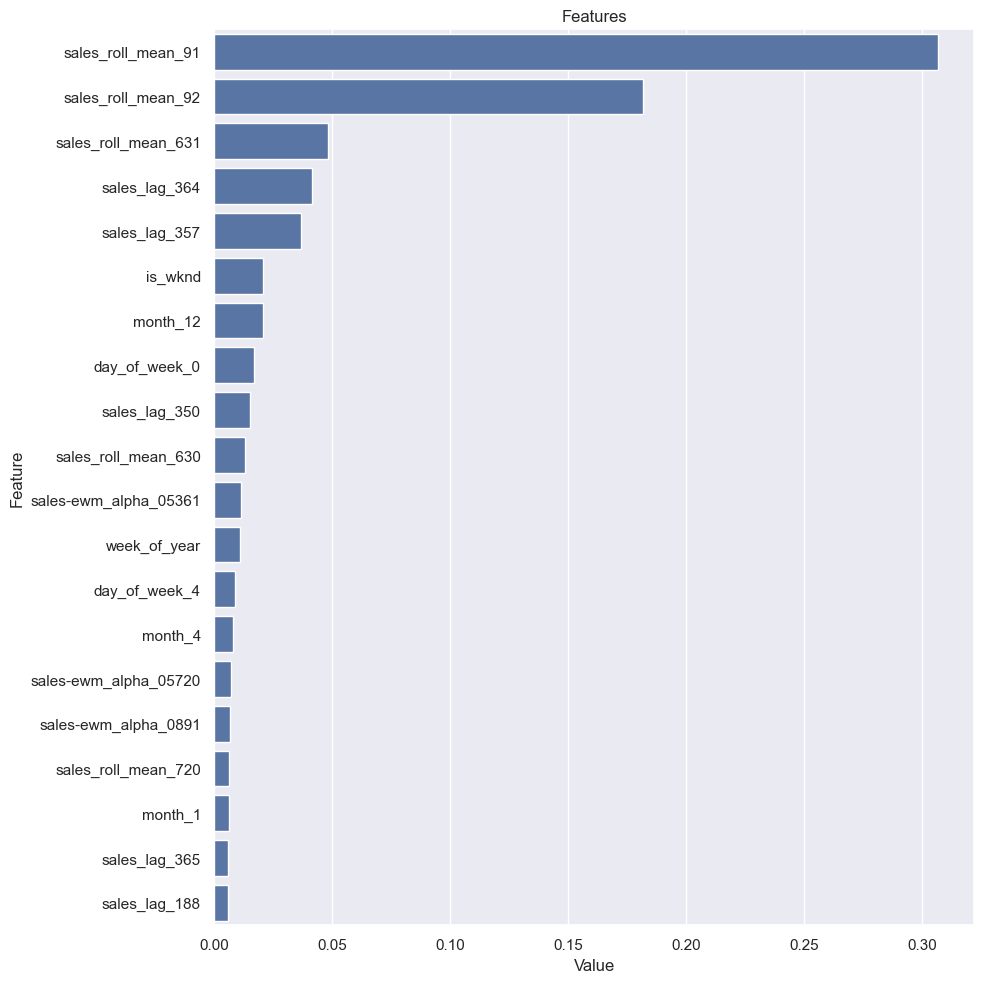

In [43]:
def plot_importance(model, features, num=None, save=False):
    if num is None:
        num = len(features.columns)

    feature_imp = pd.DataFrame({
        "Value": model.feature_importances_,
        "Feature": features.columns
    })

    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)

    sns.barplot(
        x="Value",
        y="Feature",
        data=feature_imp.sort_values(by="Value", ascending=False).head(num)
    )

    plt.title("Features")
    plt.tight_layout()
    plt.show()

    if save:
        plt.savefig("importances.png")

    return feature_imp

feature_imp = plot_importance(model=model_1, features=X_train, num=20)

In [44]:
feature_imp = feature_imp.sort_values(by="Value", ascending = False)
feature_imp.head(10)

,Value,Feature
64,0.307,sales_roll_mean_91
65,0.182,sales_roll_mean_92
82,0.048,sales_roll_mean_631
47,0.041,sales_lag_364
40,0.037,sales_lag_357
3,0.021,is_wknd
266,0.021,month_12
248,0.017,day_of_week_0
34,0.015,sales_lag_350
81,0.013,sales_roll_mean_630


In [45]:
feature_imp.describe().T

,count,mean,std,min,25%,50%,75%,max
Value,267.000,0.004,0.022,0.000,0.000,0.000,0.002,0.307


In [46]:
X_train_new = X_train[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]
X_val_new = X_val[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]

In [47]:
Y_train.shape, X_train_new.shape, Y_val.shape, X_val_new.shape

((730500,), (730500, 58), (45000,), (45000, 58))

<a id="7"></a>
## Model Building

In [49]:
def evaluate_model(true, predicted):
    mae = mean_absolute_error(true, predicted)
    mse = mean_squared_error(true, predicted)
    rmse = np.sqrt(mean_squared_error(true, predicted))
    return mae, rmse

In [50]:
models = {
    "XGBoost Regressor": XGBRegressor(),
    "LGBMRegressor": LGBMRegressor()
}

In [51]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_new, Y_train)

    y_train_pred = model.predict(X_train_new)
    y_val_pred = model.predict(X_val_new)


    model_train_mae, model_train_rmse = evaluate_model(Y_train, y_train_pred)
    model_val_mae, model_val_rmse = evaluate_model(Y_val, y_val_pred)

    print(list(models.keys())[i])
    print("Model performance for Training Set")
    print("Root Mean Squared Error: ", model_train_rmse)
    print("Mean Absolute Error: ", model_train_mae)

    print("---------------------------------")

    print("Model performance for Val Set")
    print("Root Mean Squared Error: ", model_val_mae)
    print("Mean Absolute Error: ", model_val_rmse)

    print("-------------------------------")
    print("\n")

XGBoost Regressor
Model performance for Training Set
Root Mean Squared Error:  0.16644028311970313
Mean Absolute Error:  0.12684209712428046
---------------------------------
Model performance for Val Set
Root Mean Squared Error:  0.1339278464237563
Mean Absolute Error:  0.1764555590676619
-------------------------------




  File "C:\Users\okand\anaconda3\Lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
               ^^^^^^^^^^^^^^^
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 548, in run
    with Popen(*popenargs, **kwargs) as process:
         ^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 1026, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "C:\Users\okand\anaconda3\Lib\subprocess.py", line 1538, in _execute_child
    hp, ht, pid, tid = _winapi.CreateProcess(executable, args,
                       ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.098466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 6739
[LightGBM] [Info] Number of data points in the train set: 730500, number of used features: 58
[LightGBM] [Info] Start training from score 3.789881
LGBMRegressor
Model performance for Training Set
Root Mean Squared Error:  0.16967671247261917
Mean Absolute Error:  0.12911310717104796
---------------------------------
Model performance for Val Set
Root Mean Squared Error:  0.13461259258756558
Mean Absolute Error:  0.17713917338783722
-------------------------------




<a id="8"></a>
## Hyperparameter Optimization

In [56]:
tscv = TimeSeriesSplit(n_splits=3)

def objective(trial):

    params = {
        "learning_rate": trial.suggest_categorical("learning_rate", [0.01, 0.05, 0.1, 0.3]),
        "max_depth": trial.suggest_categorical("max_depth", [3,5,7,None]),
        "n_estimators": trial.suggest_categorical("n_estimators", [100, 300, 500, 1000]),
        "colsample_bytree": trial.suggest_categorical("colsample_bytree", [0.6, 0.8, 1.0]),
        "subsample": 1.0,          
        "objective": "reg:squarederror",
        "tree_method": "hist",
        "eval_metric": "rmse",
        "random_state": 42,
        "early_stopping_rounds": 50
    }

    fold_rmse = []

    for train_index, valid_index in tscv.split(X_train_new):

        X_train_fold = X_train_new.iloc[train_index]
        y_train_fold = Y_train.iloc[train_index]

        X_valid_fold = X_train_new.iloc[valid_index]
        y_valid_fold = Y_train.iloc[valid_index]

        model = XGBRegressor(**params)

        model.fit(
            X_train_fold, y_train_fold,
            eval_set=[(X_valid_fold, y_valid_fold)],
            verbose=False
        )

        preds = model.predict(X_valid_fold)
        rmse = mean_squared_error(y_valid_fold, preds, squared=False)
        fold_rmse.append(rmse)

    return sum(fold_rmse) / len(fold_rmse)

study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=15, show_progress_bar=True)

print("Best params:", study.best_params)
print("Best RMSE:", study.best_value)

[I 2025-12-10 21:51:16,837] A new study created in memory with name: no-name-fe3c783f-a1fc-40d2-bf53-531cb2a7a5b1


  0%|          | 0/15 [00:00<?, ?it/s]

[I 2025-12-10 21:51:42,868] Trial 0 finished with value: 0.17193063986725796 and parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.8}. Best is trial 0 with value: 0.17193063986725796.
[I 2025-12-10 21:52:25,530] Trial 1 finished with value: 0.17076437462107955 and parameters: {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 500, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.17076437462107955.
[I 2025-12-10 21:52:49,473] Trial 2 finished with value: 0.17175188749296466 and parameters: {'learning_rate': 0.3, 'max_depth': 5, 'n_estimators': 300, 'colsample_bytree': 0.6}. Best is trial 1 with value: 0.17076437462107955.
[I 2025-12-10 21:53:13,821] Trial 3 finished with value: 0.1733713281393647 and parameters: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 300, 'colsample_bytree': 1.0}. Best is trial 1 with value: 0.17076437462107955.
[I 2025-12-10 21:53:38,064] Trial 4 finished with value: 0.1707891744033555 and paramet

In [78]:
model = XGBRegressor(**study.best_params).fit(X_train_new, Y_train)

y_pred_val = model.predict(X_val_new)

### Custom Cost Function:

SMAPE: Symetric mean absolute percentage error (adjusted MAPE)

In [86]:
def smape(preds, target):
    n = len(preds)
    masked_arr = ~((preds == 0) & (target == 0))
    preds, target = preds[masked_arr], target[masked_arr]
    num = np.abs(preds - target)
    denom = np.abs(preds) + np.abs(target)
    smape_val = (200 * np.sum(num/denom)) / n
    return smape_val

def lgbm_smape(preds, train_data):
    labels=train_data.get_label()
    smape_val = smape(np.expm1(preds), np.expm1(labels))
    return "SMAPE", smape_val, False

In [88]:
smape(np.expm1(y_pred_val), np.expm1(Y_val))

13.547303598330183

Our model makes predictions with an average margin of error of 13%.

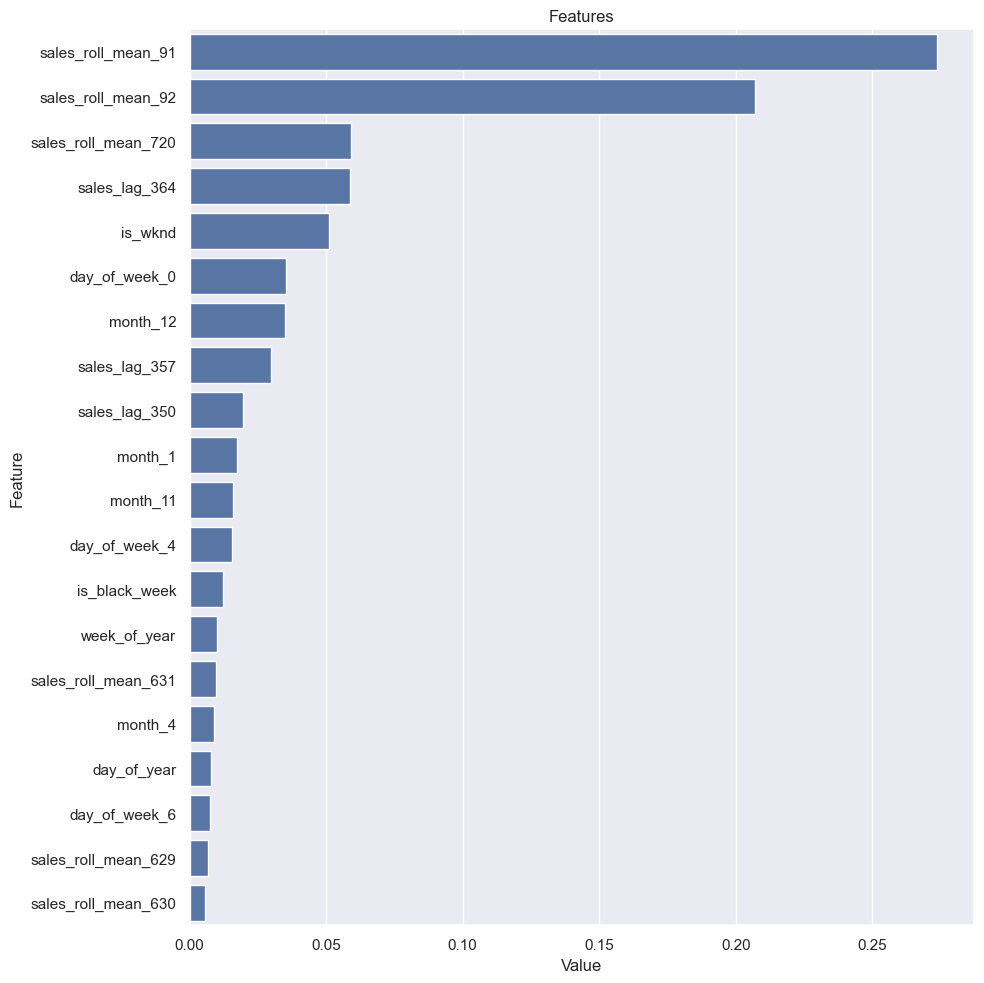

,Value,Feature
0,0.274,sales_roll_mean_91
1,0.207,sales_roll_mean_92
2,0.010,sales_roll_mean_631
3,0.059,sales_lag_364
4,0.030,sales_lag_357
5,0.051,is_wknd
6,0.035,month_12
7,0.035,day_of_week_0
8,0.019,sales_lag_350
9,0.006,sales_roll_mean_630


In [91]:
# Feature importances

plot_importance(model=model, features=X_train_new, num=20)

### Observing the results

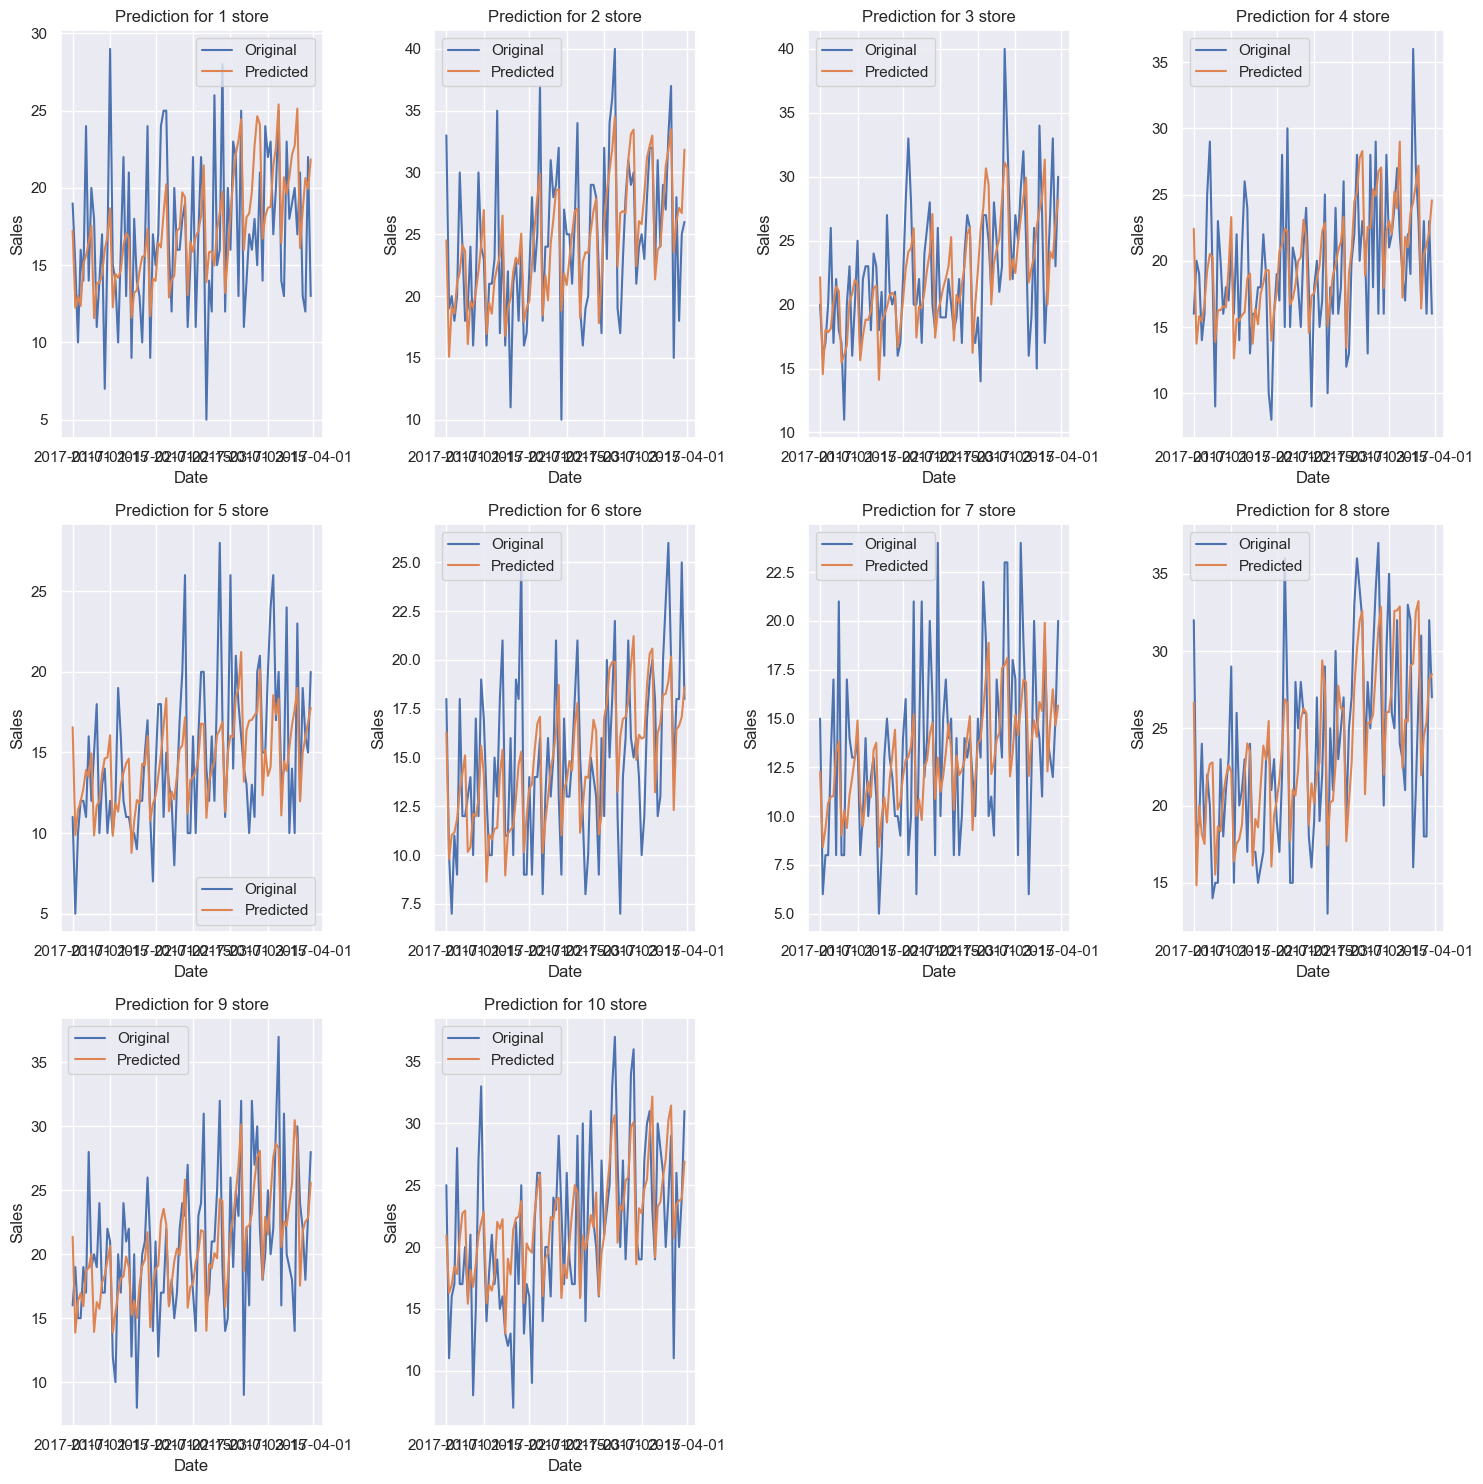

In [100]:
train2 = pd.read_csv("train.csv",parse_dates=["date"])
val2 = train2.loc[(train2["date"] >= "2017-01-01") & (train2["date"] < "2017-04-01"), :]
val2["Prediction"] = np.expm1(y_pred_val)

def observing_results_plot(dataframe, item=2):
    plt.figure(figsize=(15,15))
    stores = dataframe["store"].unique()
    for ax, store_id in enumerate(stores):
        data = dataframe[(dataframe["store"] == store_id) & (dataframe["item"] == item)]
        plt.subplot(3,4, ax+1)
        plt.title("Prediction for {} store".format(store_id))
        plt.plot(data["date"], data["sales"], label="Original")
        plt.plot(data["date"], data["Prediction"], label="Predicted")
        plt.xlabel('Date')
        plt.ylabel('Sales')
        plt.legend()
    plt.tight_layout()
    plt.show()


observing_results_plot(val2, item=1)

## Final Model

In [104]:
train = df.loc[~df.sales.isna()]
Y_train = train["sales"]
X_train = train[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]

test = df.loc[df.sales.isna()]
X_test = test[feature_imp[feature_imp["Value"]>=0.002]["Feature"]]

In [106]:
final_model = XGBRegressor(**study.best_params).fit(X_train, Y_train)

test_preds = model.predict(X_test)

submission_df = test.loc[:, ["id","sales"]]
submission_df["sales"] = np.expm1(test_preds)

submission_df.head()

,id,sales
0,0.000,12.436
1,1.000,16.318
2,2.000,14.202
3,3.000,14.472
4,4.000,17.223


In [108]:
submission_df["id"] = submission_df["id"].astype(int)
submission_df.head()

,id,sales
0,0,12.436
1,1,16.318
2,2,14.202
3,3,14.472
4,4,17.223


In [110]:
submission_df.to_csv("submission_demand_2.csv", index = False)